# Inhalt
- Häufigkeit Farbwörter / Objektname
- Häufigkeit Farbwörter / Synsets
- Gruppieren von Synsets in Kategorien
- Häufigkeit Farbwörter / Kategorie

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from ijson import items
import json
from pprint import pprint 
from nltk.corpus import wordnet as wn
import nltk
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

In [16]:
def is_hyponym(hypo, hyper):
    """ return True if 'hyper' is part of the hypernym path of 'hypo' """
    if type(hyper) != list:
        hyper = [hyper]
    for path in wn.synset(hypo).hypernym_paths():
        for h in hyper:
            if wn.synset(h) in path:
                return True
    return False

def hypernym(synset):
    hyper = synset.hypernyms()
    if len(hyper) > 0:
        return (hyper)
    return [synset]

def one_dim_list(lst):
    result = []
    for l in lst:
        for i in l:
            result.append(i)
    return result

def assign_class (synset, classes):
    for cl in classes: 
        for s in synset:
            if s in classes[cl]:
                return cl
    return None

In [18]:
color_attributes = pd.read_csv(vg_json_export+"color_terms_attributes_ish.csv", index_col=0)

## häufigste Objekte mit Farbattributen

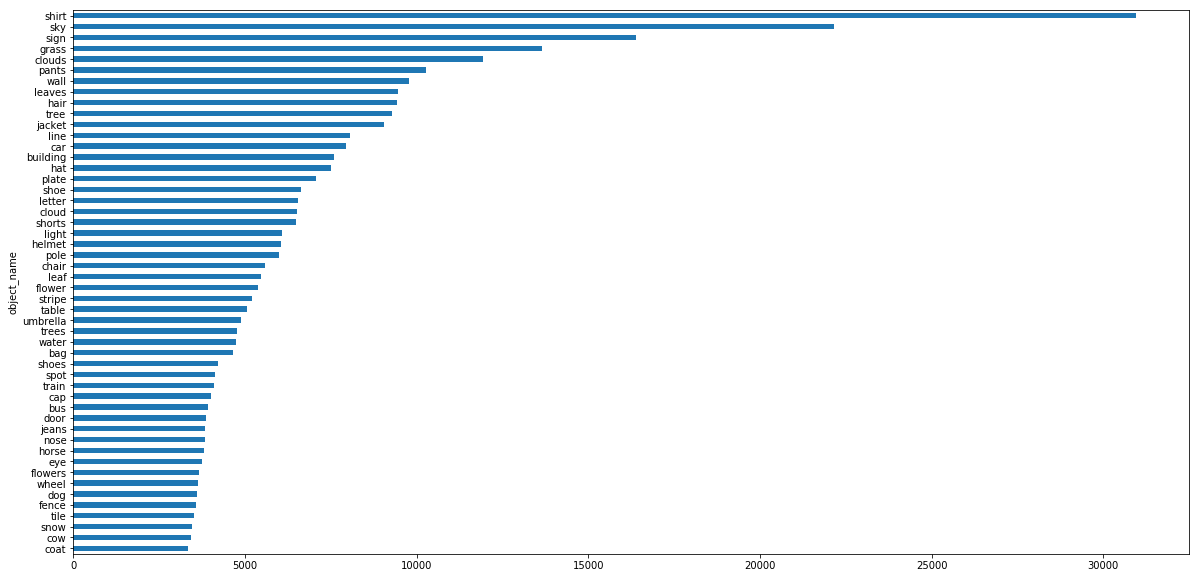

In [19]:
objects = color_attributes.groupby(['object_name']).size().sort_values(ascending=False)
objects.head(50).sort_values().plot(kind="barh", figsize=(20,10))

## häufigste Synsets

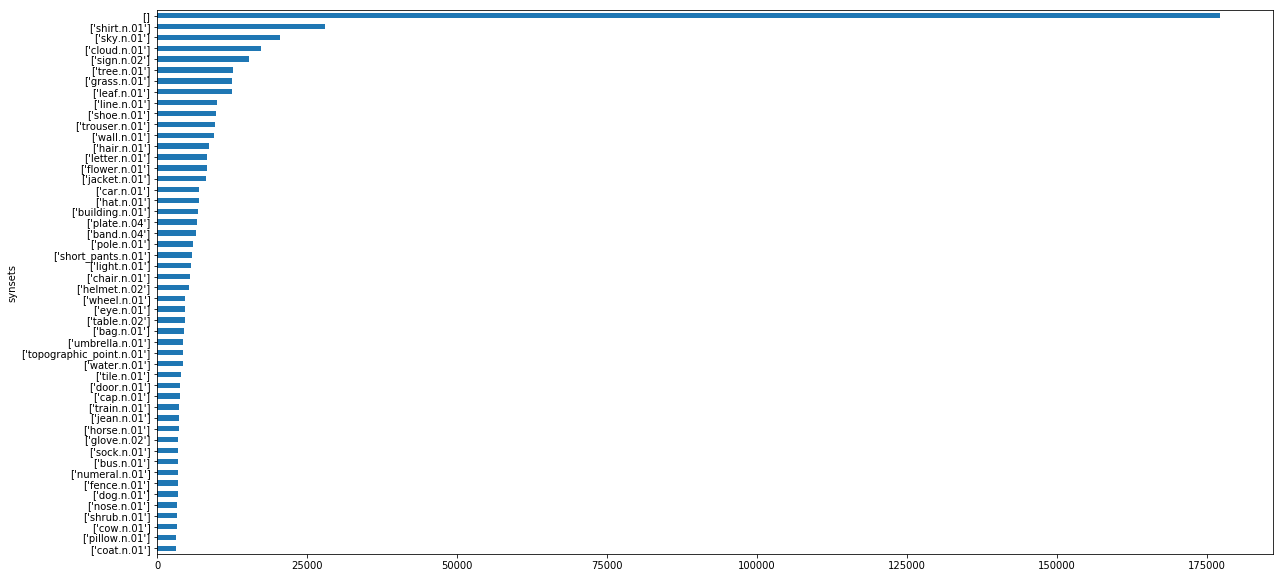

In [20]:
synsets = color_attributes.groupby(['synsets']).size().sort_values(ascending=False)
synsets.head(50).sort_values().plot(kind="barh", figsize=(20,10))

In [24]:
synsets = color_attributes.groupby(['synsets', 'object_name']).size().sort_values(ascending=False).reset_index(name='count')
synsets.head()

synsets object_name  count
0  ['shirt.n.01']       shirt  25566
1    ['sky.n.01']         sky  19024
2   ['sign.n.02']        sign  13622
3  ['grass.n.01']       grass  11799
4  ['cloud.n.01']      clouds  10069

In [25]:
#synsets = synsets.reset_index(name='count').sort_values('count', ascending=False)
synsets = synsets[synsets['synsets'] != "[]"]
synsets = synsets[synsets['count'] >= 20]
synsets.synsets = synsets.synsets.map(lambda x:eval(x))
#synsets

In [26]:
all_synsets = []
for synset in synsets.synsets:
    for s in synset:
        all_synsets.append(s)

synset_classes = {i:[] for i in\
    "person animal plant food decoration natural_phenomenon bodypart clothing furniture utensils device structure geological_formation implement substance transport signs_and_signals abstract natural_object object other".split()}

for entry in all_synsets:
    done = False
    if is_hyponym(entry, 'person.n.01'):
        synset_classes["person"].append(entry)
        done = True
    if is_hyponym(entry, 'animal.n.01'):
        synset_classes["animal"].append(entry)
        done = True
    if is_hyponym(entry, 'plant.n.02 plant_part.n.01'.split()):
        synset_classes["plant"].append(entry)
        done = True
    if is_hyponym(entry, 'food.n.01 food.n.02'.split()):
        synset_classes["food"].append(entry)
        done = True
    if is_hyponym(entry, 'body_part.n.01 hair.n.01'.split()):
        synset_classes["bodypart"].append(entry)
        done = True
    if is_hyponym(entry, 'clothing.n.01 footwear.n.02 bag.n.01 band.n.07 cloth_covering.n.01'.split()):
        synset_classes["clothing"].append(entry)
        done = True
    if is_hyponym(entry, 'furniture.n.01 furnishing.n.02 padding.n.01 fixture.n.01 seat.n.01'.split()):
        synset_classes["furniture"].append(entry)
        done = True
    if is_hyponym(entry, 'structure.n.01 building_material.n.01 horizontal_surface.n.01 roof.n.01 way.n.06'.split()):
        synset_classes["structure"].append(entry)
        done = True
    if is_hyponym(entry, 'substance.n.01'):
        synset_classes["substance"].append(entry)
        done = True
    if is_hyponym(entry, 'conveyance.n.03 tire.n.01'.split()):
        synset_classes["transport"].append(entry)
        done = True
    if is_hyponym(entry, ['pole.n.01', 'sign.n.02', 'visual_signal.n.01']):
        synset_classes["signs_and_signals"].append(entry)
        done = True
    if is_hyponym(entry, ['decoration.n.01']):
        synset_classes["decoration"].append(entry)
        done = True
    if is_hyponym(entry, ['symbol.n.01', 'text.n.01', 'line.n.01', 'verbal_creation.n.01', 'written_communication.n.01', 'language_unit.n.01']):
        synset_classes["abstract"].append(entry)
        done = True
    if is_hyponym(entry, 'implement.n.01'):
        synset_classes["implement"].append(entry)
        done = True
    if is_hyponym(entry, 'device.n.01 telecommunication.n.01 appliance.n.02'.split()):
        synset_classes["device"].append(entry)
        done = True
    if is_hyponym(entry, 'natural_object.n.01 wave.n.01 body_of_water.n.01'.split()):
        synset_classes["natural_object"].append(entry)
        done = True
    if is_hyponym(entry, 'natural_phenomenon.n.01 atmosphere.n.05'.split()):
        synset_classes["natural_phenomenon"].append(entry)
        done = True
    if is_hyponym(entry, 'geological_formation.n.01'.split()):
        synset_classes["geological_formation"].append(entry)
        done = True
        
    if done == False and is_hyponym(entry, 'tableware.n.01 canopy.n.03 container.n.01 utensil.n.01 plaything.n.01 equipment.n.01 board.n.03 linen.n.03'.split()):
        synset_classes["utensils"].append(entry)
        done = True
        
    
    if done == False and is_hyponym(entry, 'object.n.01'):
        synset_classes["object"].append(entry)
        done = True
        
        
    if done == False: 
        synset_classes["other"].append(entry)
    
for key in synset_classes:
    print (key,len(synset_classes[key]))

person 58
animal 74
plant 121
food 91
decoration 45
natural_phenomenon 27
bodypart 85
clothing 218
furniture 72
utensils 123
device 151
structure 158
geological_formation 11
implement 50
substance 86
transport 82
signs_and_signals 32
abstract 72
natural_object 96
object 203
other 186


In [ ]:
synset = 'point.n.09'
#wn.synset("jacket.n.01").common_hypernyms(wn.synset("shirt.n.01"))
print (wn.synset(synset).definition())
print ('hypernyms:')
pprint(wn.synset(synset).hypernyms())
print ('hyponyms:')
pprint(wn.synset(synset).hyponyms())

pprint (synset_classes["other"])

In [27]:
object_categories = pd.read_csv(vg_json_export+"color_terms_attributes.csv", index_col=0)
object_categories.synsets = object_categories.synsets.map(lambda x:eval(x))
object_categories['category'] = object_categories.synsets.map(lambda x: assign_class(x,synset_classes))

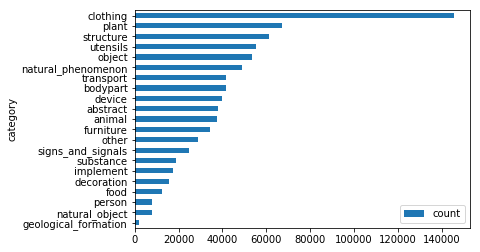

In [28]:
categories = object_categories.groupby('category').size().reset_index(name='count').sort_values('count')
categories.set_index('category').plot(kind='barh')

In [30]:
object_categories.loc[object_categories['category'] == 'object']\
    .groupby(['category', 'object_name']).size()\
    .reset_index(name='count').sort_values('count',ascending=False)\
    .head()


category object_name  count
1000   object        spot   3197
1062   object        tile   3171
539    object      handle   2722
526    object      ground   2275
1077   object       towel   1951

## Wörter mit häufigsten Farbattributen

In [3]:
objects = pd.read_csv(vg_json_export+"object_attributes.csv", index_col=0)
color_attributes = pd.read_csv(vg_json_export+"color_terms_attributes_ish.csv", index_col=0)

objects = objects.groupby('object_name').size().reset_index(name='count_all').sort_values('count_all', ascending=False)\
    .merge(color_attributes.groupby('object_name').size().reset_index(name='count_colour'), how='inner', on='object_name')

objects['ratio'] = objects.apply(lambda x: (x.count_colour/x.count_all), axis=1)

/home/simeon/Dokumente/Programmieren/Python/Environments/visualgenome/lib/python3.7/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
objects.loc[objects['count_all'] >= 200]\
.sort_values('ratio', ascending=True)

object_name  count_all  count_colour     ratio
329       distance       1946             1  0.000514
472      spectator       1229             1  0.000814
689          right        690             1  0.001449
795   glass window        544             1  0.001838
20          people      22040            41  0.001860
537         couple        989             2  0.002022
873           meal        468             1  0.002137
975        wrinkle        399             1  0.002506
679      left hand        700             2  0.002857
1045        silver        347             1  0.002882
1053         waist        343             1  0.002915
227            men       2949             9  0.003052
1106       someone        316             1  0.003165
1150    man's head        293             1  0.003413
1161    two people        289             1  0.003460
333            the       1922             7  0.003642
790     restaurant        547             2  0.003656
1212          down        270             1  0.003704
1226      railroad        264             1  0.003788
526          crowd       1030             4  0.003883
1245        family        255             1  0.003922
828            zoo        508             2  0.003937
640     right hand        747             3  0.004016
1300   little girl        240             1  0.004167
1386       surfers        217             1  0.004608
718       children        632             3  0.004747
1415            up        210             1  0.004762
1420            an        208             1  0.004808
628     spectators        774             4  0.005168
769           kids        570             3  0.005263
...            ...        ...           ...       ...
774          laces        563           348  0.618117
43            line      12973          8052  0.620674
275           vest       2369          1475  0.622626
870         sheets        470           293  0.623404
524         ribbon       1040           649  0.624038
29           pants      16332         10263  0.628398
953        t shirt        412           259  0.628641
846        marking        493           311  0.630832
1024          pant        361           230  0.637119
335           trim       1909          1219  0.638554
147        letters       5041          3222  0.639159
84          stripe       8115          5204  0.641282
501         outfit       1131           727  0.642794
142           coat       5184          3333  0.642940
40          jacket      13932          9050  0.649584
893         tshirt        451           295  0.654102
305        t-shirt       2124          1391  0.654896
1467          grip        200           133  0.665000
851     wrist band        489           326  0.666667
922      tee shirt        435           290  0.666667
711           tarp        662           442  0.667674
298          socks       2169          1460  0.673121
480     tablecloth       1216           819  0.673520
244      lettering       2798          1892  0.676197
264           cone       2483          1679  0.676198
5            shirt      45755         30964  0.676735
581       tank top        869           591  0.680092
943         blouse        419           287  0.684964
203           sock       3263          2293  0.702728
506      wristband       1113           820  0.736748

[1468 rows x 4 columns]